# COURSERA CAPSTONE FINAL PROJECT, WEEKS 4 & 5

## Find the best location to open a fitness nutrition shop in Toronto

## Import required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

### Import and explore Toronto postalcode areas

In [2]:
# import data frame
df=pd.read_csv('Toronto_neighborhoods_WithGeospacial.csv')
df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [3]:
print('The dataframe has {} boroughs and {} Neighborhood.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 Neighborhood.


#### Use geopy library to get the latitude and longitude values of Toronto.

In [4]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with Neighborhoods superimposed on top.

In [5]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'],\
                                           df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## Define Foursquare Credentials and Version

In [6]:
# Note that these credentials are saved in Credentials.csv which is not shared on github
Cred_data=pd.read_csv('Credentials.csv')
CLIENT_ID='5LJOJSOHCGXQDQPSJGY3GRZIHB2EJWJEL2ANTCZOUV0FIL5L'#Cred_data['CLIENT_ID'][0]
CLIENT_SECRET='TDF2G1JALYUMVXS0KRN0E4GTOV2WGPW041IBZVDKYJSGVQ43'#Cred_data['CLIENT_SECRET'][0]
VERSION=Cred_data['VERSION'][0]
LIMIT=Cred_data['LIMIT'][0]

**Fetch Foursquare Venue Category Hierarchy**

In [7]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [8]:
with open('category_results.json', 'w') as f:
    json.dump(category_results, f)

In [9]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [10]:
category_list = category_results['response']['categories']
len(category_list)

10

In [11]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


**_Outdoors & Recreation_ & It's Sub-Categories**

Let's create a function to return a dictionary with Ids' & Names of _Outdoors & Recreation_ & It's Sub-Categories.

In [12]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [13]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06377d81259')

In [14]:
category_dict

{'4d4b7105d754a06377d81259': 'Outdoors & Recreation',
 '4f4528bc4b90abdf24c9de85': 'Athletics & Sports',
 '52e81612bcbc57f1066b7a2b': 'Badminton Court',
 '4bf58dd8d48988d1e8941735': 'Baseball Field',
 '4bf58dd8d48988d1e1941735': 'Basketball Court',
 '52e81612bcbc57f1066b7a2f': 'Bowling Green',
 '56aa371be4b08b9a8d57351a': 'Curling Ice',
 '4bf58dd8d48988d1e6941735': 'Golf Course',
 '58daa1558bbb0b01f18ec1b0': 'Golf Driving Range',
 '4bf58dd8d48988d175941735': 'Gym / Fitness Center',
 '52f2ab2ebcbc57f1066b8b47': 'Boxing Gym',
 '503289d391d4c4b30a586d6a': 'Climbing Gym',
 '52f2ab2ebcbc57f1066b8b49': 'Cycle Studio',
 '4bf58dd8d48988d105941735': 'Gym Pool',
 '52f2ab2ebcbc57f1066b8b48': 'Gymnastics Gym',
 '4bf58dd8d48988d176941735': 'Gym',
 '4bf58dd8d48988d101941735': 'Martial Arts Dojo',
 '58daa1558bbb0b01f18ec203': 'Outdoor Gym',
 '5744ccdfe4b0c0459246b4b2': 'Pilates Studio',
 '4bf58dd8d48988d106941735': 'Track',
 '590a0744340a5803fd8508c3': 'Weight Loss Center',
 '4bf58dd8d48988d102941735

Now, we have all the categories in _Outdooes and recreation_ with their id's.

#### Explore the first Neighborhood to understand the results of GET Request

Get the Neighborhood's name.

In [15]:
df.loc[0, 'Neighborhood']

'Parkwoods'

Get the Neighborhood's latitude and longitude values.

In [16]:
neighborhood_latitude = df.loc[0, 'Latitude'] # Neighborhood area latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # Neighborhood area longitude value

neighborhood_name = df.loc[0, 'Postalcode'] # postalcode name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of M3A are 43.7532586, -79.3296565.


#### Now, let's get the _Sport & Recreation_ that is in ... within a radius of 500 meters.

First, let's create the GET request URL to search for Venue with requested _Category ID_

In [17]:
LIMIT = 10 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06377d81259' # category ID for "Sport & Recreation"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=5LJOJSOHCGXQDQPSJGY3GRZIHB2EJWJEL2ANTCZOUV0FIL5L&client_secret=TDF2G1JALYUMVXS0KRN0E4GTOV2WGPW041IBZVDKYJSGVQ43&v=20180604&ll=43.7532586,-79.3296565&radius=500&categoryId=4d4b7105d754a06377d81259&limit=10'

Send the GET request and examine the resutls

In [18]:
results = requests.get(url).json()

In [19]:
results['response']['venues'][0]

{'id': '4e8d9dcdd5fbbbb6b3003c7b',
 'name': 'Brookbanks Park',
 'location': {'address': 'Toronto',
  'lat': 43.751976046055574,
  'lng': -79.33214044722958,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.751976046055574,
    'lng': -79.33214044722958}],
  'distance': 245,
  'cc': 'CA',
  'city': 'Toronto',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['Toronto', 'Toronto ON', 'Canada']},
 'categories': [{'id': '4bf58dd8d48988d163941735',
   'name': 'Park',
   'pluralName': 'Parks',
   'shortName': 'Park',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1589513521',
 'hasPerk': False}

The category name of the venue **'Brookbanks Park'** is **'Parks'**.

As, our aim is to segment the neighborhoods of Toronto with respect to the _Sport & Recreation_ in its vicinity. We need to proceed further to fetch this data from all the 103 neighborhoods' venues.

#### Let's create a function to repeat the following process to all the postalcode areas in Toronto:
* Loop through postalcodes
    * Create the API request URL with radius=500, LIMIT=100
    * Make the GET request
    * For each postalcode, return only relevant information for each nearby venue
    * Append all nearby venues to a list
* Unfold the list & append it to dataframe being returned

The _categoryId_ parameter in the API request URL can be a comma seperated string. So, lets create a comma seperated string from _category_\__dict_.

In [20]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

The above process turns out to be redundant because if a top-level category is specified in the GET Request, all sub-categories will also match the query. But it is an interesting way to retrieve all the sub-categories ID with name.

In [21]:
def getNearbySport(names, latitudes, longitudes, radius=500, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06377d81259", # "Sport and Recreation" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

**Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.**

In [22]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('Toronto_sport_venues.pkl', 'rb') as f:
        Toronto_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues = getNearbySport(names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    with open('Toronto_sport_venues.pkl', 'wb') as f:
        pickle.dump(Toronto_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


## 3. Analysis & Machine Learning

#### Let's check the size of the resulting dataframe

In [23]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1476, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Eagle Bridge,43.750453,-79.332259,Bridge
2,Parkwoods,43.753259,-79.329656,GreenWin pool,43.756232,-79.333842,Pool
3,Parkwoods,43.753259,-79.329656,Brookbanks Pool,43.751389,-79.332184,Pool
4,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


#### Let's find out how many unique categories can be curated from all the returned venues

In [24]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))
Toronto_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 83 uniques categories.


Venue Category
Park                                        224
Gym                                         217
Gym / Fitness Center                        141
Other Great Outdoors                        113
Athletics & Sports                           87
Playground                                   78
Yoga Studio                                  70
Pool                                         60
Garden                                       37
Dog Run                                      36
Skating Rink                                 31
Scenic Lookout                               30
Martial Arts Dojo                            26
Plaza                                        26
Tennis Court                                 23
Gym Pool                                     19
Bridge                                       17
Field                                        16
Sculpture Garden                             16
Farm                                         14
Basketball Court         

In [25]:
# list all the categories
unique_categories = Toronto_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Park, Bridge, Pool, Hockey Arena, Other Great Outdoors, Gym / Fitness Center, Playground, Gym, Historic Site, Yoga Studio, General Travel, Distribution Center, Surf Spot, Sculpture Garden, Dog Run, Botanical Garden, Forest, Dive Spot, Skating Rink, Soccer Field, Harbor / Marina, Beach, Athletics & Sports, Boxing Gym, Field, Lake, Scenic Lookout, Gym Pool, Trail, Baseball Field, Garden, Martial Arts Dojo, Golf Driving Range, Tennis Court, Plaza, Skate Park, College Rec Center, Monument / Landmark, Roof Deck, Office, Hotel Pool, Outdoors & Recreation, Curling Ice, Indoor Play Area, Sporting Goods Shop, Pilates Studio, Basketball Court, College Gym, Recreation Center, Summer Camp, Cemetery, Arcade, Flower Shop, Stables, Golf Course, Community Center, Mountain, Sporting Event, Well, Residential Building (Apartment / Condo), Lighthouse, Farm, Pet Service, Tanning Salon, Campground, Stadium, Climbing Gym, Cycle Studio, Sports Club, General Entertainment, College Stadium, Ski Area, Swim Schoo

In [26]:
# manually create a list of most common fitness and sport related categories
general_categories = ['Gym / Fitness Center','Gym']

In [27]:
len(general_categories)

2

Revise the results to keep only venues in the list of general categories

In [28]:
Toronto_venues = Toronto_venues[Toronto_venues['Venue Category'].isin(general_categories)].reset_index()
Toronto_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,6,Victoria Village,43.725882,-79.315572,Toronto Dance Vibe,43.720892,-79.311882,Gym / Fitness Center
1,11,"Regent Park, Harbourfront",43.654260,-79.360636,Lift Corktown,43.656475,-79.357258,Gym
2,13,"Regent Park, Harbourfront",43.654260,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center
3,14,"Regent Park, Harbourfront",43.654260,-79.360636,Corktown District Lofts Gym,43.655652,-79.358125,Gym
4,21,"Regent Park, Harbourfront",43.654260,-79.360636,Think Fitness,43.652985,-79.355914,Gym / Fitness Center


### Analyze Each neighborhood

In [29]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot.head()

,Gym,Gym / Fitness Center
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1


In [30]:
# sum all gyms
all_Gym=Toronto_onehot['Gym']+Toronto_onehot['Gym / Fitness Center']
Toronto_onehot['all_Gym']=all_Gym
Toronto_onehot.drop(['Gym','Gym / Fitness Center'],axis=1,inplace=True)
Toronto_onehot.head()

,all_Gym
0,1
1,1
2,1
3,1
4,1


In [31]:
Toronto_venues.shape

(358, 8)

In [32]:
Toronto_onehot.shape

(358, 1)

In [33]:
# add Postalcode column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 
Toronto_onehot.head()

,all_Gym,Neighborhood
0,1,Victoria Village
1,1,"Regent Park, Harbourfront"
2,1,"Regent Park, Harbourfront"
3,1,"Regent Park, Harbourfront"
4,1,"Regent Park, Harbourfront"


In [34]:
# move neighborhood column to the first column
Neighborhood = Toronto_onehot['Neighborhood']

Toronto_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot.insert(0, 'Neighborhood', Neighborhood)

Toronto_onehot.head()

,Neighborhood,all_Gym
0,Victoria Village,1
1,"Regent Park, Harbourfront",1
2,"Regent Park, Harbourfront",1
3,"Regent Park, Harbourfront",1
4,"Regent Park, Harbourfront",1


And let's examine the new dataframe size.

In [35]:
Toronto_onehot.shape

(358, 2)

Let's count venues of each category in each neighborhood

In [36]:
venue_counts = Toronto_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,all_Gym
Neighborhood,
Agincourt,1
"Alderwood, Long Branch",3
"Bedford Park, Lawrence Manor East",2
Berczy Park,14
"Brockton, Parkdale Village, Exhibition Place",7


Let's find out the top 10 sport categories in Toronto

In [37]:
venue_counts_described = venue_counts.describe().transpose()

In [38]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
all_Gym,62.0,5.774194,5.403154,1.0,1.0,3.0,9.75,21.0


In [39]:
venue_top10_list = venue_top10.index.values.tolist()

In [40]:
venue_top10_list 

['all_Gym']

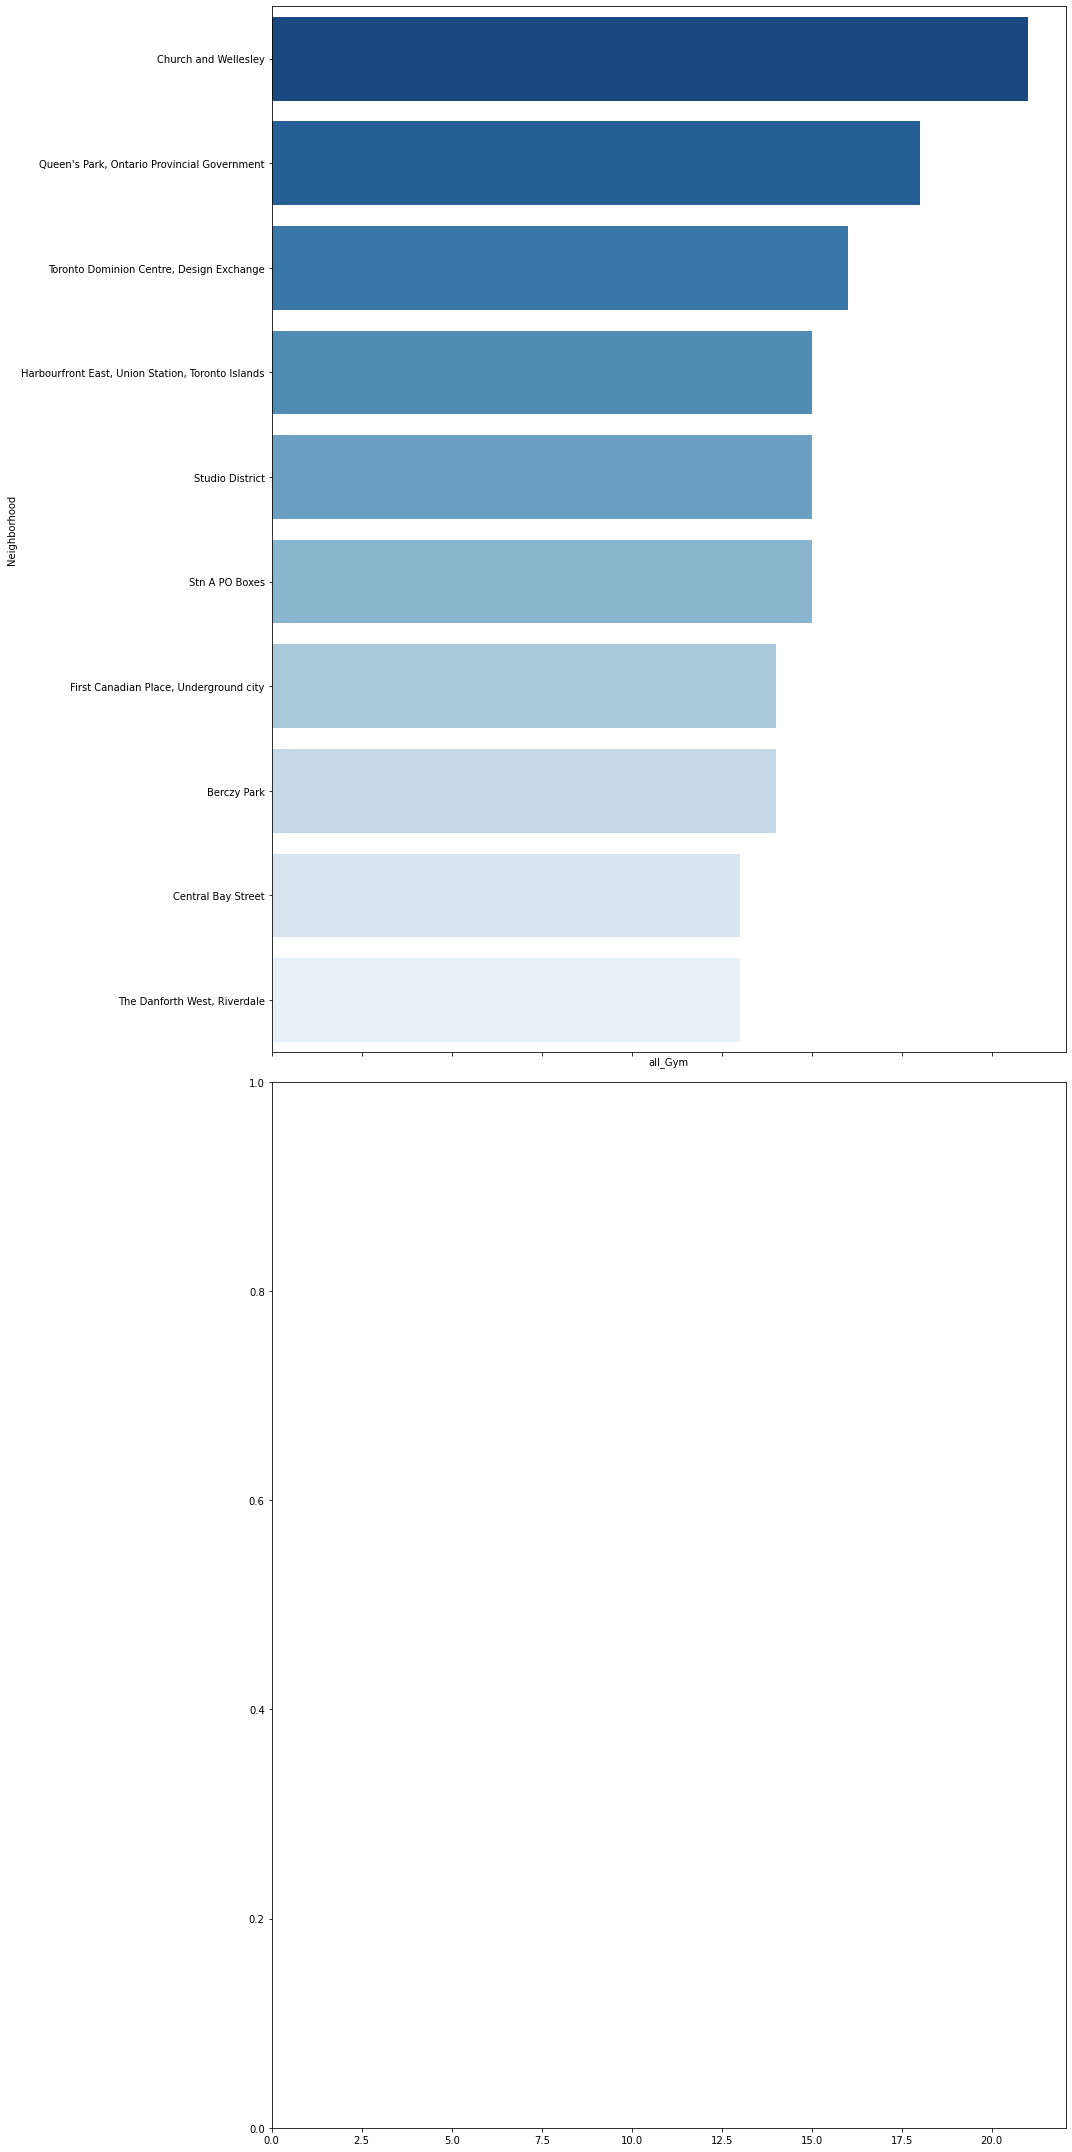

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(2, 1, figsize=(15,30), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [42]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').count().reset_index()
Toronto_grouped

,Neighborhood,all_Gym
0,Agincourt,1
1,"Alderwood, Long Branch",3
2,"Bedford Park, Lawrence Manor East",2
3,Berczy Park,14
4,"Brockton, Parkdale Village, Exhibition Place",7
5,Business reply mail Processing Centre,3
6,Canada Post Gateway Processing Centre,5
7,Cedarbrae,2
8,Central Bay Street,13
9,Christie,4


#### Let's confirm the new size

In [43]:
Toronto_grouped.shape

(62, 2)

#### Let's write a function to sort the venues in descending order.

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [45]:
num_top_venues = 1

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))  
        
columns

['Neighborhood', '1st Most Common Venue']

In [46]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue
0,Agincourt,NaN
1,"Alderwood, Long Branch",NaN
2,"Bedford Park, Lawrence Manor East",NaN
3,Berczy Park,NaN
4,"Brockton, Parkdale Village, Exhibition Place",NaN


In [47]:
for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue
0,Agincourt,all_Gym
1,"Alderwood, Long Branch",all_Gym
2,"Bedford Park, Lawrence Manor East",all_Gym
3,Berczy Park,all_Gym
4,"Brockton, Parkdale Village, Exhibition Place",all_Gym


### Cluster Neighborhoods

Run *k*-means to count Neighborhoods for each cluster label for variable cluster size

In [48]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

#### Determine the optimal number of clusters for k-means clustering

**The Elbow Method** - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [49]:
sum_of_squared_distances = []
K = range(1,20)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(Toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  """


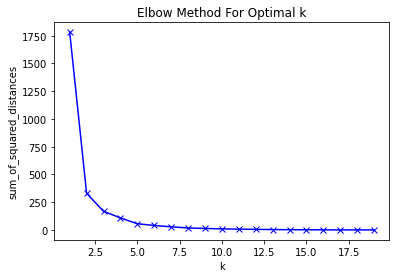

In [50]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

**The Silhouette Method** - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [51]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,20)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(Toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(Toronto_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  


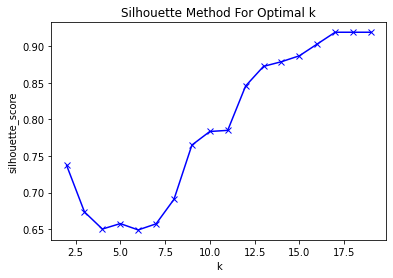

In [52]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [53]:
pd.DataFrame({'Sil':sil,'ksil':K_sil}).head(15)

,Sil,ksil
0,0.737337,2
1,0.673445,3
2,0.650059,4
3,0.657507,5
4,0.648869,6
5,0.657192,7
6,0.690784,8
7,0.764994,9
8,0.783549,10
9,0.785100,11


#### There is a peak at k = 6.
### Let's set number of clusters = 6

In [54]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(Toronto_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({0: 40, 1: 13, 2: 9})


In [55]:
kmeans.labels_

array([0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 1,
       0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 1, 2, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [56]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [57]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue
0,0,Agincourt,all_Gym
1,0,"Alderwood, Long Branch",all_Gym
2,0,"Bedford Park, Lawrence Manor East",all_Gym
3,1,Berczy Park,all_Gym
4,2,"Brockton, Parkdale Village, Exhibition Place",all_Gym


In [58]:
# merge neighborhoods_venues_sorted with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = neighborhoods_venues_sorted.join(df.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,Postalcode,Borough,Latitude,Longitude
0,0,Agincourt,all_Gym,M1S,Scarborough,43.794200,-79.262029
1,0,"Alderwood, Long Branch",all_Gym,M8W,Etobicoke,43.602414,-79.543484
2,0,"Bedford Park, Lawrence Manor East",all_Gym,M5M,North York,43.733283,-79.419750
3,1,Berczy Park,all_Gym,M5E,Downtown Toronto,43.644771,-79.373306
4,2,"Brockton, Parkdale Village, Exhibition Place",all_Gym,M6K,West Toronto,43.636847,-79.428191


Finally, let's visualize the resulting clusters

In [59]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Results

In [60]:
required_column_indices = [2,3,5]
required_column = [list(Toronto_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,5]

#### Cluster 0

In [61]:
cluster_0 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[1:12]]
cluster_0

,Neighborhood,1st Most Common Venue,Postalcode,Borough,Latitude,Longitude
0,Agincourt,all_Gym,M1S,Scarborough,43.794200,-79.262029
1,"Alderwood, Long Branch",all_Gym,M8W,Etobicoke,43.602414,-79.543484
2,"Bedford Park, Lawrence Manor East",all_Gym,M5M,North York,43.733283,-79.419750
5,Business reply mail Processing Centre,all_Gym,M7Y,East Toronto,43.662744,-79.321558
6,Canada Post Gateway Processing Centre,all_Gym,M7R,Mississauga,43.636966,-79.615819
7,Cedarbrae,all_Gym,M1H,Scarborough,43.773136,-79.239476
9,Christie,all_Gym,M6G,Downtown Toronto,43.669542,-79.422564
11,"Clarks Corners, Tam O'Shanter, Sullivan",all_Gym,M1T,Scarborough,43.781638,-79.304302
12,"Cliffside, Cliffcrest, Scarborough Village West",all_Gym,M1M,Scarborough,43.716316,-79.239476
17,"Dorset Park, Wexford Heights, Scarborough Town...",all_Gym,M1P,Scarborough,43.757410,-79.273304


In [62]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

all_Gym    44
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
M4R    1
M1W    1
M4A    1
M5T    1
M7Y    1
M6C    1
M1S    1
M4L    1
M4T    1
M1P    1
M9L    1
M2J    1
M1J    1
M8W    1
M2R    1
M1H    1
M6P    1
M8V    1
M4G    1
M4B    1
M9R    1
M6S    1
M4X    1
M5M    1
M1T    1
M4H    1
M6A    1
M4N    1
M3L    1
M1B    1
M8Z    1
M3M    1
M6H    1
M4V    1
M1L    1
M5P    1
M1V    1
M3N    1
M7R    1
M6B    1
M6G    1
M2N    1
M1M    1
M3K    1
Name: Postalcode, dtype: int64
---------------------------------------------
43.715383    1
43.709060    1
43.705369    1
43.628841    1
43.744734    1
43.778517    1
43.706397    1
43.718518    1
43.739015    1
43.696948    1
43.651571    1
43.794200    1
43.668999    1
43.756303    1
43.686412    1
43.770120    1
43.653206    1
43.711112    1
43.602414    1
43.605647    1
43.689574    1
43.661608    1
43.728496    1
43.782736    1
43.667967    1
43.725882    1
43.733283    1
43.737473    1
43.81

#### Cluster 1

In [63]:
cluster_1 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[1:12]]
cluster_1.head()

,Neighborhood,1st Most Common Venue,Postalcode,Borough,Latitude,Longitude
3,Berczy Park,all_Gym,M5E,Downtown Toronto,43.644771,-79.373306
8,Central Bay Street,all_Gym,M5G,Downtown Toronto,43.657952,-79.387383
10,Church and Wellesley,all_Gym,M4Y,Downtown Toronto,43.665860,-79.383160
13,"Commerce Court, Victoria Hotel",all_Gym,M5L,Downtown Toronto,43.648198,-79.379817
21,"First Canadian Place, Underground city",all_Gym,M5X,Downtown Toronto,43.648429,-79.382280


In [64]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

all_Gym    13
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
M5E    1
M7A    1
M5X    1
M4K    1
M5H    1
M5J    1
M5L    1
M4M    1
M5K    1
M4Y    1
M5A    1
M5W    1
M5G    1
Name: Postalcode, dtype: int64
---------------------------------------------
43.665860    1
43.662301    1
43.644771    1
43.654260    1
43.640816    1
43.659526    1
43.647177    1
43.657952    1
43.650571    1
43.648198    1
43.646435    1
43.679557    1
43.648429    1
Name: Latitude, dtype: int64
---------------------------------------------


#### Cluster 2

In [65]:
cluster_2 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[1:12]]
cluster_2.head()

,Neighborhood,1st Most Common Venue,Postalcode,Borough,Latitude,Longitude
4,"Brockton, Parkdale Village, Exhibition Place",all_Gym,M6K,West Toronto,43.636847,-79.428191
14,Davisville,all_Gym,M4S,Central Toronto,43.704324,-79.388790
15,Davisville North,all_Gym,M4P,Central Toronto,43.712751,-79.390197
16,Don Mills,all_Gym,M3B,North York,43.745906,-79.352188
16,Don Mills,all_Gym,M3C,North York,43.725900,-79.340923


In [66]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

all_Gym    10
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
M6K    1
M5R    1
M4S    1
M6J    1
M4P    1
M3C    1
M5C    1
M3B    1
M5B    1
M5S    1
Name: Postalcode, dtype: int64
---------------------------------------------
43.704324    1
43.672710    1
43.712751    1
43.725900    1
43.636847    1
43.657162    1
43.662696    1
43.745906    1
43.651494    1
43.647927    1
Name: Latitude, dtype: int64
---------------------------------------------


#### Cluster 3

In [67]:
cluster_3 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[1:12]]
cluster_3.head()

,Neighborhood,1st Most Common Venue,Postalcode,Borough,Latitude,Longitude


In [68]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Series([], Name: 1st Most Common Venue, dtype: int64)
---------------------------------------------
Series([], Name: Postalcode, dtype: int64)
---------------------------------------------
Series([], Name: Latitude, dtype: int64)
---------------------------------------------


#### Cluster 4

In [69]:
cluster_4 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,Postalcode,Borough,Latitude,Longitude


In [70]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Series([], Name: 1st Most Common Venue, dtype: int64)
---------------------------------------------
Series([], Name: Postalcode, dtype: int64)
---------------------------------------------
Series([], Name: Latitude, dtype: int64)
---------------------------------------------


#### Cluster 5

In [71]:
cluster_5 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, Toronto_merged.columns[1:12]]
cluster_5

,Neighborhood,1st Most Common Venue,Postalcode,Borough,Latitude,Longitude


In [72]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Series([], Name: 1st Most Common Venue, dtype: int64)
---------------------------------------------
Series([], Name: Postalcode, dtype: int64)
---------------------------------------------
Series([], Name: Latitude, dtype: int64)
---------------------------------------------
